In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error

In [4]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-10.parquet')

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-10-01 00:15:32,2025-10-01 01:04:03,1.0,17.20,2.0,N,132,107,1,70.0,5.00,0.5,0.00,6.94,1.0,83.44,2.5,1.75,0.75
1,7,2025-10-01 00:00:08,2025-10-01 00:00:08,1.0,5.00,1.0,N,107,225,1,28.2,0.00,0.5,8.49,0.00,1.0,42.44,2.5,0.00,0.75
2,2,2025-10-01 00:08:54,2025-10-01 00:14:44,1.0,2.75,1.0,N,263,229,1,12.8,1.00,0.5,3.71,0.00,1.0,22.26,2.5,0.00,0.75
3,1,2025-10-01 00:58:48,2025-10-01 01:04:40,1.0,1.30,1.0,N,211,231,2,7.9,4.25,0.5,0.00,0.00,1.0,13.65,2.5,0.00,0.75
4,2,2025-10-01 00:39:51,2025-10-01 00:49:40,1.0,2.88,1.0,N,230,151,1,14.2,1.00,0.5,3.99,0.00,1.0,23.94,2.5,0.00,0.75


In [6]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

df = df[(df.duration >=1) & (df.duration <=60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.55495630504871

C:\Users\Professional\AppData\Local\Temp\ipykernel_47568\2276717578.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\Professional\AppData\Local\Temp\ipykernel_47568\2276717578.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


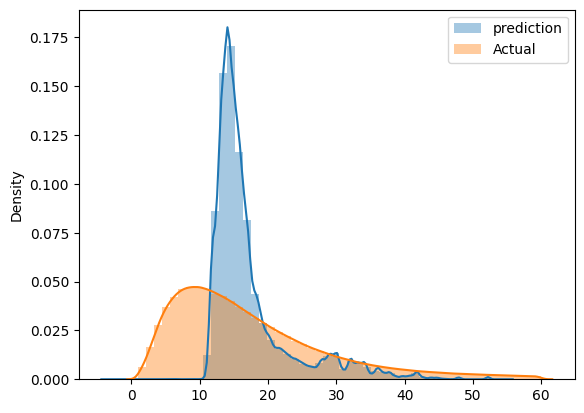

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('F:\MLOPs\data\yellow_tripdata_2025-09.parquet')
df_val = read_dataframe('F:\MLOPs\data\yellow_tripdata_2025-10.parquet')

In [14]:
len(df_train), len(df_val)

(4041830, 4198802)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [19]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.729497779095036

In [25]:
import pickle
import os
os.makedirs("models", exist_ok=True)


In [26]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)